# **Tutorial 4: Oceanic Wind-driven Circulation**

**Week 1, Day 2: State of the Climate - Ocean and Atmospheric Reanalysis**

__Content creators:__   Abigail Bodner

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Brodie Pearson, Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

The ocean's motion is driven by radiation from the sun, winds, and various sources of fresh water  (precipitation, rivers, melting and freezing ice). In the previous tutorial, we measured the surface winds around the world. The surface winds impose at the surface of the ocean which results in ocean transport, known as Ekman transport. In this tutorial, we are going to use [Estimating the Circulation and Climate of the Ocean (ECCO)](https://www.ecco-group.org/) dataset, to make the best possible estimates of ocean circulation and its role in climate.

To gain insights into the influence of near-surface winds on oceanic motion, we will analyze surface currents using the [ECCO (Estimating the Circulation and Climate of the Ocean)](https://www.ecco-group.org) reanalysis. Additionally, we will compare these surface currents with atmospheric conditions.

At the end of this tutorial you will be able to

- access and select ocean reanalysis data data
- plot annuual mean surface ocean currents and atmospheric winds
- compare circulation patterns

# Setup

In [ ]:
# !pip install pythia_datasets
!pip install cartopy
# !pip install geoviews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from intake import open_catalog
import matplotlib.pyplot as plt
import matplotlib
import os
import pooch

import numpy as np
import xarray as xr
import warnings
from cartopy import crs as ccrs, feature as cfeature
# #  Suppress warnings issued by Cartopy when downloading data files
# warnings.filterwarnings('ignore')

In [ ]:
# @title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")


def font_for_print():

    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 11
    legend_properties = {'weight':'bold'}

    plt.rc('font', size=SMALL_SIZE, serif='Helvetica Neue', weight='normal')          # controls default text sizes
    #plt.rc('font', size=SMALL_SIZE, serif='DejaVu Sans', weight='light')
    plt.rc('text', usetex='false')
    plt.rc('axes', titlesize=MEDIUM_SIZE, labelweight='normal')     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE, labelweight='normal') #, family='bold')    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE, frameon=False)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE, titleweight='bold', autolayout=True) #, family='bold')  # fontsize of the figure title

    plt.rc('axes', labelsize= SMALL_SIZE, labelweight='normal')

font_for_print()

In [ ]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# **Section 1: Loading the Data**

Load atmospheric winds at 10 meters from the surface and oceanic surface currents from ECCO reanalysis data



In [ ]:
# load data: atmospheric 10m wind from ECCO
# wind in east/west direction labeled here as 'u'
fname_atm_wind_u = 'wind_evel_monthly_2016.nc'
url_atm_wind_u = "https://osf.io/ke9yp/download"
atm_wind_u = xr.open_dataarray(pooch.retrieve(url_atm_wind_u, known_hash=None, fname=fname_atm_wind_u))
atm_wind_u

<xarray.DataArray 'EXFewind' (time: 12, latitude: 360, longitude: 720)>
[3110400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2016-01-16T12:00:00 ... 2016-12-16T12:00:00
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    units:        m/s
    long_name:    eastward 10-m wind velocity over open water, >0 increases eVel
    mate:         EXFnwind
    coordinates:  latitude timestep longitude

In [ ]:
# wind in north/south direction labeled here as 'v'
fname_atm_wind_v = 'wind_nvel_monthly_2016.nc'
url_atm_wind_v = "https://osf.io/9zkgd/download"
atm_wind_v = xr.open_dataarray(pooch.retrieve(url_atm_wind_v, known_hash=None, fname=fname_atm_wind_v))
atm_wind_v

<xarray.DataArray 'EXFnwind' (time: 12, latitude: 360, longitude: 720)>
[3110400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2016-01-16T12:00:00 ... 2016-12-16T12:00:00
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    units:        m/s
    long_name:    northward 10-m wind velocity over open water, >0 increases ...
    mate:         EXFewind
    coordinates:  latitude timestep longitude

In [ ]:
# load data: oceanic surface current from ECCO
# current in east/west direction labeled here as 'u'
fname_ocn_surface_current_u = 'evel_monthly_2016.nc'
url_ocn_surface_current_u = "https://osf.io/ndx5a/download"
ocn_surface_current_u = xr.open_dataarray(pooch.retrieve(url_ocn_surface_current_u, known_hash=None, fname=fname_ocn_surface_current_u))
ocn_surface_current_u

OSError: ignored

In [ ]:
# current in east/west direction labeled here as 'v'
fname_ocn_surface_current_v = 'nvel_monthly_2016.nc'
url_ocn_surface_current_v = "https://osf.io/qa9ex/download"
ocn_surface_current_v = xr.open_dataarray(pooch.retrieve(url_ocn_surface_current_v, known_hash=None, fname=fname_ocn_surface_current_v))
ocn_surface_current_v

<xarray.DataArray 'NVEL' (time: 12, latitude: 360, longitude: 720)>
[3110400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2014-01-16T12:00:00 ... 2014-12-16T12:00:00
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    units:          m/s
    long_name:      Northward Component of Velocity (m/s)
    standard_name:  northward_sea_water_velocity
    coordinates:    latitude timestep Z longitude

Examine the time frequency or temporal frequency of one of the ECCO variables, which is the rate at which reanalysis data is provided. Here we choose 'atm_wind_u' but they should all be the same!

In [ ]:
atm_wind_u.time

<xarray.DataArray 'time' (time: 12)>
array(['2016-01-16T12:00:00.000000000', '2016-02-15T12:00:00.000000000',
       '2016-03-16T12:00:00.000000000', '2016-04-16T00:00:00.000000000',
       '2016-05-16T12:00:00.000000000', '2016-06-16T00:00:00.000000000',
       '2016-07-16T12:00:00.000000000', '2016-08-16T12:00:00.000000000',
       '2016-09-16T00:00:00.000000000', '2016-10-16T12:00:00.000000000',
       '2016-11-16T00:00:00.000000000', '2016-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-01-16T12:00:00 ... 2016-12-16T12:00:00
Attributes:
    long_name:  center time of averaging period
    bounds:     time_bnds
    axis:       T

## **Questions 1**
1. Why do you think the atmospheric reanalysis dataset from the previous tutorial (ERA5) has higher output frequency than the ECCO ocean reanalysis dataset?
2. What can we infer about the rate of change of the two systems and their role in the climate system from these output frequencies?
3. What type of averaging would we need to perform on ERA5 dataset in order to compare directly with ECCO?

In [ ]:
# to_remove explanation

"""
1. The atmospheric dataset typically has a higher output frequency than the ocean dataset due to the different timescales on which the atmosphere and the ocean respond to changes. The atmosphere is more volatile and can change rapidly over minutes to hours, while the ocean, due to its high thermal inertia and slower currents, changes more slowly.
2. atmosphere plays a faster, more immediate role in the climate system. It reacts quickly to heat and pressure differences, driving weather changes. The ocean, on the other hand, plays a longer-term role in the climate system and provides a buffering effect against rapid atmospheric changes.
3. To compare the ERA5 atmospheric dataset directly with the ECCO ocean dataset, we would need to perform temporal averaging on the ERA5 data to match the output frequencies. For example, computing monthly averages from the higher-frequency atmospheric data to match the output frequency of the ECCO dataset.
""";


# **Section 2: Plotting Global Surface Wind Stress Annual Mean**

Now, we will generate global maps displaying the annual mean of atmospheric 10m winds.

We first compute the annual mean of the surface wind  variables. We do so by averaging over the time dimention using .mean(dim='time'). Since we have monthly data spanning only one year, .mean(dim='time') will give the annual mean of the year 2016.


In [ ]:
# compute the annual mean of atm_wind_u
atm_wind_u_anu_mean = atm_wind_u.mean(dim='time')
atm_wind_u_anu_mean

<xarray.DataArray 'EXFewind' (latitude: 360, longitude: 720)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.14805873, 1.14805873, 1.14805873, ..., 1.14805873, 1.14805873,
        1.14805873],
       [1.03043525, 1.03043525, 1.03043525, ..., 1.03043525, 1.03043525,
        1.03043525],
       [0.60513089, 0.60513089, 0.60513089, ..., 0.60513089, 0.60513089,
        0.60513089]])
Coordinates:
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

In [ ]:
# take the annual mean of atm_wind_stress_v
atm_wind_v_anu_mean = atm_wind_v.mean(dim='time')
atm_wind_v_anu_mean

<xarray.DataArray 'EXFnwind' (latitude: 360, longitude: 720)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.29360731, 0.29360731, 0.29360731, ..., 0.29360731, 0.29360731,
        0.29360731],
       [0.25386951, 0.25386951, 0.25386951, ..., 0.25386951, 0.25386951,
        0.25386951],
       [0.64899328, 0.64899328, 0.64899328, ..., 0.64899328, 0.64899328,
        0.64899328]])
Coordinates:
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

We are now almost ready to plot! However, instead of plotting the zonal and meridional velocity components $(u,v)$ separately, we will create a plot that represents the magnitude and direction of the total velocity vector. This type of plot is known as a vector field. A [vector](https://glossary.ametsoc.org/wiki/Vector) is a special mathematical quantity that has both magnitude and direction, just like the wind! The velocity components describe the intensity of wind blowing in the zonal ($u$) or meridional ($v$) directions. Specifically, wind can blow eastward (positive $u$) or westward (negative $u$), as well as northward (positive $v$) or southward (negative $v$).

The total velocity vector is the *vector sum* of these two components and exhibits varying magnitude and direction. The magnitude ($||u||$) and direction ($θ$) of the total velocity vector can be determined using the following equations:

\begin{align}
||u|| = \sqrt{u^2 + v^2},  \ \  \ \ \theta = tan^{-1}(\frac{v}{u})
\end{align}

When plotting a vector field using a computer, it is commonly referred to as a quiver plot. In our case, we will utilize a [quiver function created by Ryan Abernathey](https://rabernat.github.io/intro_to_physical_oceanography/07_ekman.html) that calculates the magnitude and direction of the total velocity vector based on the given zonal and meridional components.

We will overlay the quiver plot on top of the annual mean ocean surface temperature (labeled here as theta), simmilar to the one we made in the previous tutorial, but with the ECCO dataset.

In [ ]:
fname_surface_temp = 'surface_theta.nc'
url_fname_surface_temp = "https://osf.io/98ksr/download"
ocn_surface_temp = xr.open_dataarray(pooch.retrieve(url_fname_surface_temp, known_hash=None, fname=fname_surface_temp))
ocn_surface_temp


SHA256 hash of downloaded file: 2d8db6d497acec50c4d0753ba69c610231dc02294ab1dc99640e0fce0285d369
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.DataArray 'THETA' (latitude: 360, longitude: 720)>
[259200 values with dtype=float64]
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...

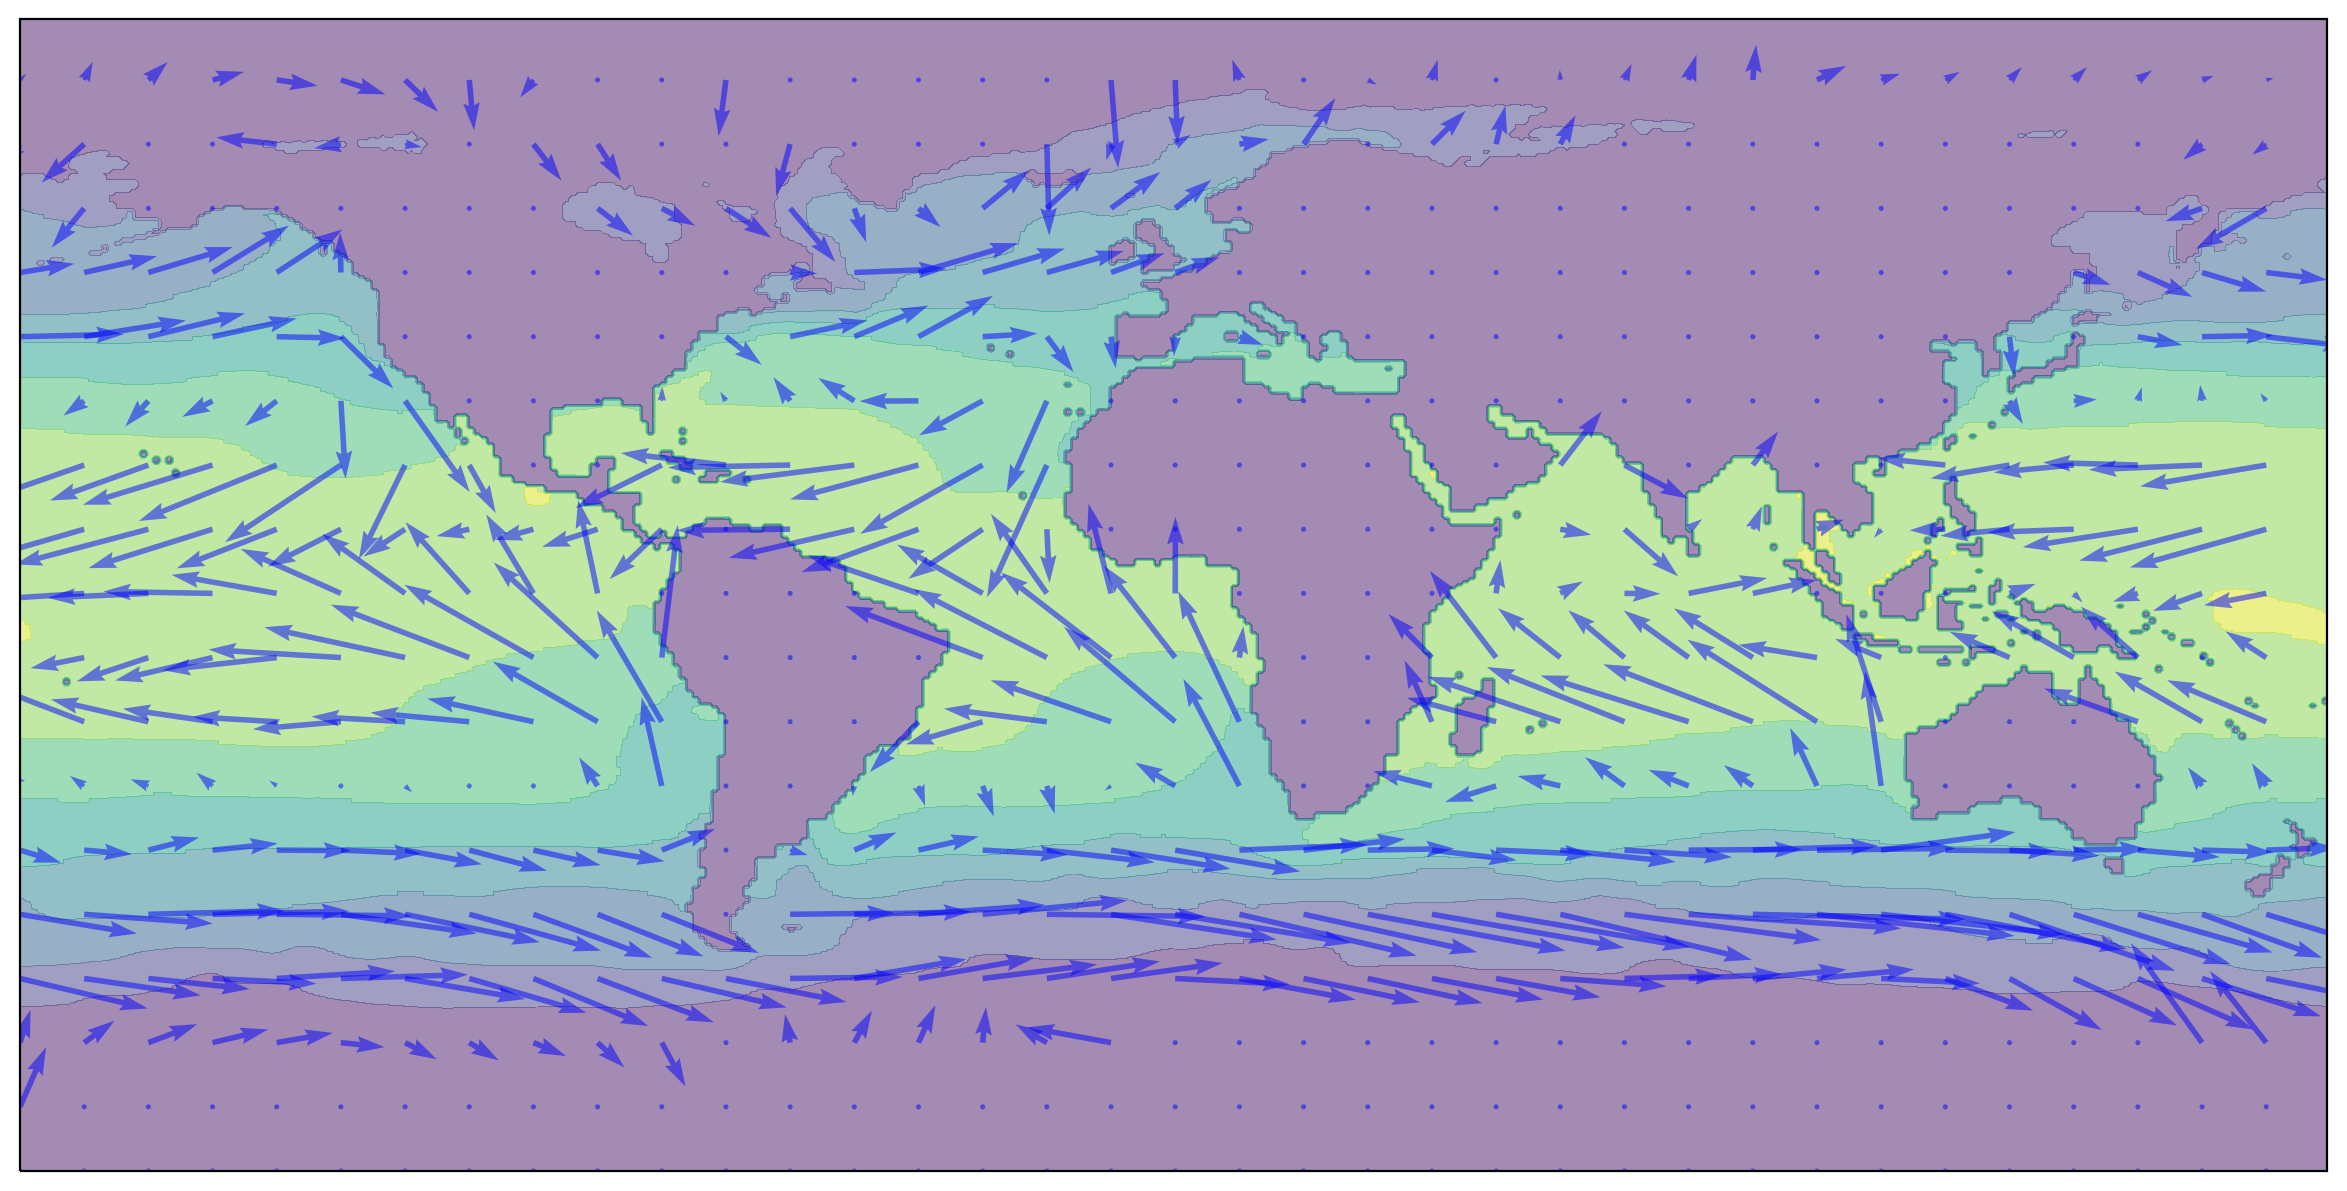

In [ ]:
# longitude ad latitude coordinates for plotting
lon = atm_wind_u_anu_mean.longitude
lat = atm_wind_u_anu_mean.latitude

# calculate magnitude of total velocity
mag = (atm_wind_u_anu_mean**2 + atm_wind_v_anu_mean**2)**0.5

# coarsen the grid so the arrows are distinguishable by only selecting
# some longitudes and latitudes defined by sampling_x and sampling_y.
slx = slice(None, None, 20)
sly = slice(None, None, 20)
sl2d = (sly, slx)

#fig, ax = plt.subplots(**kwargs)
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

plt.contourf(lon,lat,ocn_surface_temp, alpha=0.5)

# plot quiver arrows indicating vector direction (winds are in blue, alpha is for opacity)
ax.quiver(lon[slx],lat[sly],atm_wind_u_anu_mean[sl2d],atm_wind_v_anu_mean[sl2d],color='b', alpha=0.5)

# Section 3: Plotting Global Surface Currents Using ECCO

We now compute the annual mean of the ocean surface currents, same as we did above for the atmospehric winds.

In [ ]:
# take the annual mean of ocn_surface_current_u
ocn_surface_current_u_anu_mean = ocn_surface_current_u.mean(dim='time')
ocn_surface_current_u_anu_mean

NameError: ignored

In [ ]:
# take the annual mean of ocn_surface_current_v
ocn_surface_current_v_anu_mean = ocn_surface_current_v.mean(dim='time')
ocn_surface_current_v_anu_mean

<xarray.DataArray 'NVEL' (latitude: 360, longitude: 720)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00707205, 0.00707205, 0.00707205, ..., 0.00707205, 0.00707205,
        0.00707205],
       [0.00721859, 0.00721859, 0.00721859, ..., 0.00721859, 0.00721859,
        0.00721859],
       [0.01465764, 0.01465764, 0.01465764, ..., 0.01465764, 0.01465764,
        0.01465764]])
Coordinates:
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

Now let's add quiver arrows to the plot above, this time corresponding to ocean surface currents.

NameError: ignored

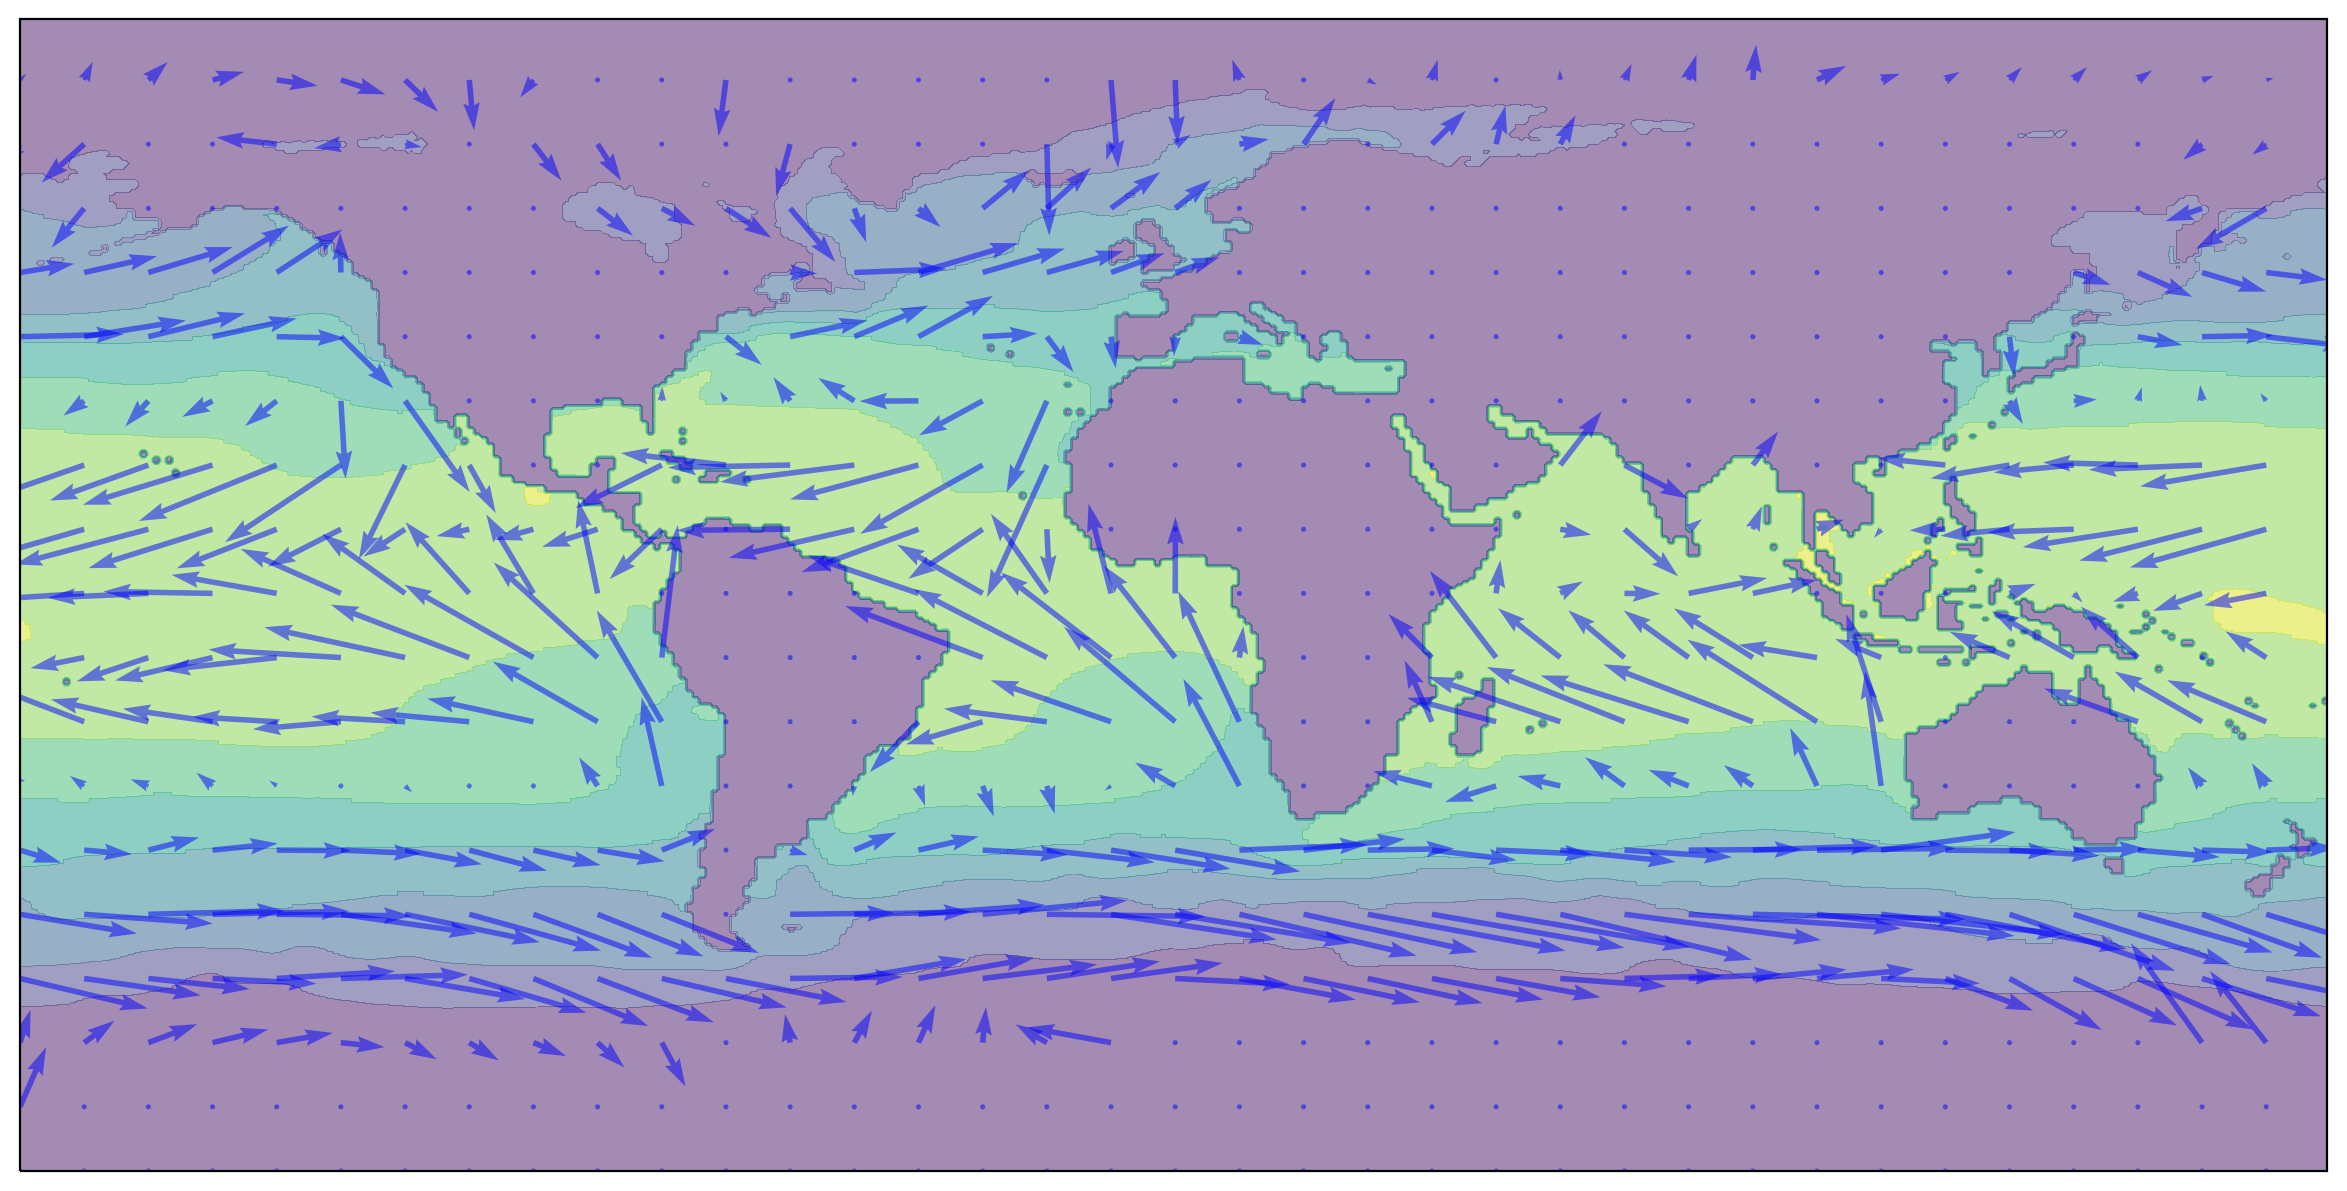

In [ ]:
# longitude ad latitude coordinates for plotting
lon = atm_wind_u_anu_mean.longitude
lat = atm_wind_u_anu_mean.latitude

# calculate magnitude of total velocity
mag = (atm_wind_u_anu_mean**2 + atm_wind_v_anu_mean**2)**0.5

# coarsen the grid so the arrows are distinguishable by only selecting
# some longitudes and latitudes defined by sampling_x and sampling_y.
slx = slice(None, None, 20)
sly = slice(None, None, 20)
sl2d = (sly, slx)

#fig, ax = plt.subplots(**kwargs)
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

plt.contourf(lon,lat,ocn_surface_temp, alpha=0.5)

# plot quiver arrows indicating vector direction (winds are in blue, alpha is for opacity)
ax.quiver(lon[slx],lat[sly],atm_wind_u_anu_mean[sl2d],atm_wind_v_anu_mean[sl2d],color='b', alpha=0.5)

# plot quiver arrows indicating vector direction (ocean currents are in green, alpha is for opacity)
ax.quiver(lon[slx],lat[sly],ocn_surface_current_u_anu_mean[sl2d],ocn_surface_current_v_anu_mean[sl2d],color='g', alpha=0.5)

You may notice that the surface currents are not purfectly aligned with the wind direction. In fact, they flow at an angle of approximately 45 degrees. This phenomenon is known as the [Ekman pumping effect](https://en.wikipedia.org/wiki/Ekman_transport), where water is either upwelled or downwelled depending on the direction of the wind. Can you observe this relationship? Is it the same in both the Northern and Southern Hemispheres?



## *Bonus*:
Upwelling and downwelling play a significant role in the El Niño phenomenon we discussed earlier. The phases of El Niño and La Niña are identified by the presence of either strong or weak upwelling near the coast.


Make a plot near the coast of Peru to examine the relationship between wind, upwelling, and temperature in this area. What do you observe?

# Summary




In this tutorial, we've delved into the mechanisms that shape ocean currents, specifically the role of wind in driving these currents. We've explored the concept of "*surface stress*", a frictional force created by wind across the water surface, initiating the movement of ocean currents. We've further examined the intricacies of "*wind-driven circulation*", a system whereby ocean currents are predominantly powered by surface winds, influencing global climate and biogeochemical cycles. Utilizing the ECCO dataset, we've also gained practical skills in accessing and analyzing ocean reanalysis data.

However, we can observe that the wind-driven circulation alone does not account for all the ocean currents. In the next tutorial we will learn about the density-driven currents.


# **Resources**